# package和数据导入

## 包导入

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn_modified')
import keras
layers = keras.layers
models = keras.models
optimizers = keras.optimizers

Using Theano backend.


In [2]:
# pandas设置
pd.options.display.max_columns = 10

## 数据导入

In [3]:
eload = pd.read_excel("LoadData.xlsx", parse_dates=True, index_col='YMD')
# eload.set_axis(range(0,24*60, 15),axis=1, inplace=True)
eload.set_axis(np.linspace(0, 24, 96, endpoint=False),axis=1, inplace=True)
eload.dropna(inplace=True)
eload.head()

,0.0,0.25,0.5,0.75,1.0,...,22.75,23.0,23.25,23.5,23.75
YMD,,,,,,,,,,,
2009-01-01,3210.842464,3104.507008,3037.705984,2960.176288,2889.226528,...,2734.114816,2610.683872,2485.757536,2382.696928,2276.210080
2009-01-02,2163.988288,2074.737568,1999.624960,1950.288448,1889.142112,...,3964.573792,3774.516256,3587.174176,3424.568608,3266.948608
2009-01-03,3109.127008,3015.901120,2938.305664,2869.375744,2815.772224,...,4127.941984,3955.490752,3774.541120,3602.281312,3444.148000
2009-01-04,3307.752544,3209.726368,3125.514016,3075.184864,3028.708768,...,4124.856256,3940.387648,3767.990560,3602.398720,3477.076768
2009-01-05,3295.415776,3278.379328,3232.313632,3160.731232,3124.226368,...,4710.734656,4471.342144,4295.259520,4106.356096,3933.511360


In [4]:
weather = pd.read_excel("LoadData.xlsx", sheet_name='Area1_Weather',
                        parse_dates=True, index_col='YMD')
weather.dropna(inplace=True)
weather.head()

,最高温度℃,最低温度℃,平均温度℃,相对湿度(平均),降雨量（mm）
YMD,,,,,
2012-01-01,19.5,12.1,15.8,63.0,0.0
2012-01-02,20.0,13.0,16.0,59.0,0.0
2012-01-03,18.7,14.2,15.8,72.0,0.0
2012-01-04,14.9,9.3,10.9,62.0,0.0
2012-01-05,9.2,5.1,6.9,78.0,2.9


## 负荷长期趋势

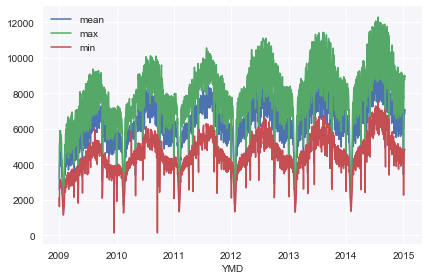

In [5]:
eload.mean(axis=1).plot(label='mean')
eload.max(axis=1).plot(label='max')
eload.min(axis=1).plot(label='min')
plt.legend()
plt.show()

# 数据标准化

## min-max 标准化

In [6]:
minmax = eload.apply(lambda x:((x.T-x.T.min()) / (x.T.max()-x.T.min())).T) # Min-Max标准化

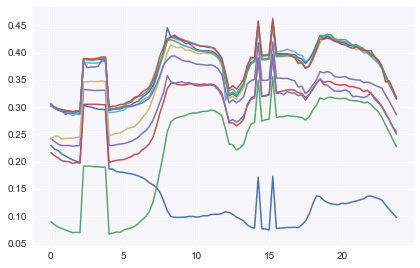

In [7]:
minmax.iloc[:10].T.plot()
plt.legend('')
plt.show()

Apparently, min-max 标准化不是一个合适的处理方式。

## z-score 标准化

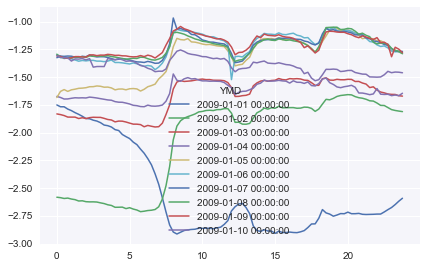

In [8]:
base = eload.mean(axis=0)
std = eload.std(axis=0)
eload.subtract(base, axis=1).div(std, axis=1)[:10].T.plot()

看起来前10天的负荷都在平均线以下

In [9]:
base = eload.mean(axis=1)
std = eload.std(axis=1)
zscore = eload.sub(base, axis=0).div(std, axis=0) # Z-score 标准化，减小长期趋势的影响

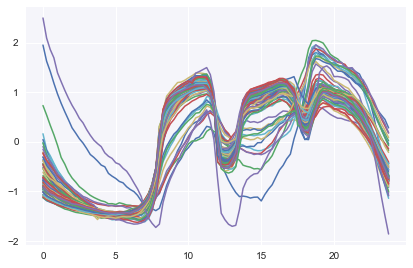

In [10]:
zscore.iloc[:100].T.plot()
plt.legend('')
plt.show()

### 两个方向都标准化试试

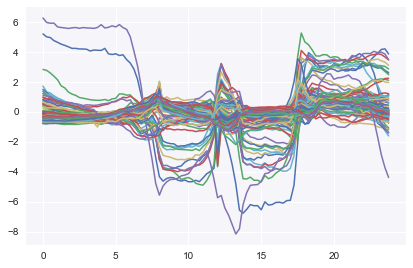

In [11]:
zscore.sub(zscore.mean(), axis=1).div(zscore.std(), axis=1)[:100].T.plot()
plt.legend('')
plt.show()

## 数据准备

In [12]:
regload = zscore.reindex(weather.index).dropna()
regweather = weather.sub(weather.mean(), axis=1).div(weather.std(), axis=1).reindex(regload.index).dropna()

In [13]:
# Data split
train_data = regweather[:800]
val_data = regweather[800:1000]
test_data = regweather[1000:]
train_tar = regload[:800]
val_tar = regload[800:1000]
test_tar = regload[1000:]

# 构建模型

In [14]:
model = models.Sequential()

In [15]:
model.add(layers.Dense(32, input_shape=(len(train_data.columns),),
                       activation = 'relu'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(96))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [16]:
# 超参数设置
EPOCHS = 20

In [17]:
his = model.fit(train_data, train_tar, epochs=EPOCHS, validation_data=(val_data, val_tar))

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 0s 39us/step - loss: 0.8744 - mean_absolute_error: 0.8159 - val_loss: 0.7085 - val_mean_absolute_error: 0.7175
Epoch 2/20
800/800 [==============================] - 0s 59us/step - loss: 0.5072 - mean_absolute_error: 0.5865 - val_loss: 0.3552 - val_mean_absolute_error: 0.4742
Epoch 3/20
800/800 [==============================] - 0s 59us/step - loss: 0.2621 - mean_absolute_error: 0.3941 - val_loss: 0.2030 - val_mean_absolute_error: 0.3266
Epoch 4/20
800/800 [==============================] - 0s 39us/step - loss: 0.1643 - mean_absolute_error: 0.2950 - val_loss: 0.1559 - val_mean_absolute_error: 0.2661
Epoch 5/20
800/800 [==============================] - 0s 59us/step - loss: 0.1275 - mean_absolute_error: 0.2475 - val_loss: 0.1298 - val_mean_absolute_error: 0.2330
Epoch 6/20
800/800 [==============================] - 0s 59us/step - loss: 0.1052 - mean_absolute_error: 0.2184 - val_loss: 0.107

In [18]:
train_loss = his.history['loss']
val_loss = his.history['val_loss']
train_mae = his.history['mean_absolute_error']
val_mae = his.history['val_mean_absolute_error']
epoch = np.linspace(1, EPOCHS, num=EPOCHS)

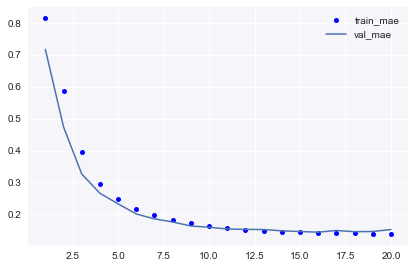

In [19]:
plt.plot(epoch, train_mae, 'bo', label = 'train_mae')
plt.plot(epoch, val_mae, label = 'val_mae')
plt.legend()
plt.show()

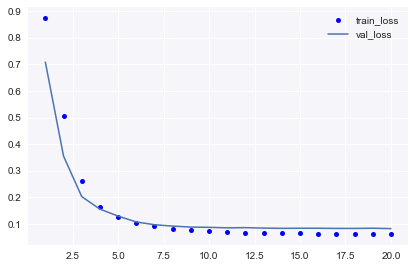

In [20]:
plt.plot(epoch, train_loss, 'bo', label = 'train_loss')
plt.plot(epoch, val_loss, label = 'val_loss')
plt.legend()
plt.show()

## 模型优化

In [186]:
# 待补充

# 预测

In [21]:
model.evaluate(test_data, test_tar)

104/104 [==============================] - 0s 0us/step


[0.07021398133096787, 0.14669916893427187]

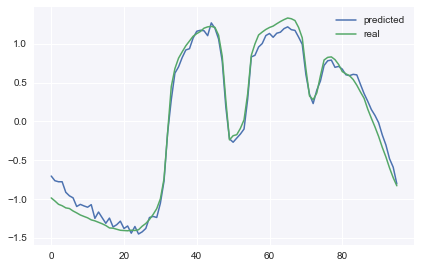

In [22]:
plt.plot(model.predict(test_data[10:11]).T)
plt.plot(test_tar[10:11].values.T)
plt.legend(['predicted','real'])
plt.show()